In [1]:
import torch
import numpy as np
import rasterio
import dl_toolbox.inference as dl_inf
from dl_toolbox.lightning_modules import *
from dl_toolbox.torch_datasets import *


#CKPT_PATH = '/work/OT/ai4usr/fournip/outputs/digi_toulouse_num_train/version_0/checkpoints/epoch=499-step=31499.ckpt'
#CKPT_PATH = '/work/OT/ai4usr/fournip/outputs/semcity_num_train/version_7/checkpoints/epoch=399-step=25199.ckpt'
CKPT_PATH = '/work/OT/ai4usr/fournip/outputs/par6all_ce_te01/version_1/checkpoints/epoch=149-step=23399.ckpt'
IN_CHANNELS = 3
NUM_CLASSES = 6
ENCODER = 'efficientnet-b1'
#LABEL_PATH = '/work/OT/ai4usr/fournip/miniworld_tif/christchurch/test/10_y.tif'
#LABEL_PATH = '/work/OT/ai4usr/fournip/SemCity-Toulouse-bench/semantic_05/TLS_GT/TLS_GT_01_1.tif'
LABEL_PATH = '/work/OT/ai4usr/fournip/digitanie/Paris/paris_tuile_1.tif'
#IMAGE_PATH = '/d/pfournie/ai4geo/data/DIGITANIE/Toulouse/toulouse_tuile_6_img_normalized.tif'
#IMAGE_PATH = '/work/OT/ai4usr/fournip/miniworld_tif/christchurch/test/10_x.tif'
IMAGE_PATH = '/work/OT/ai4usr/fournip/digitanie/Paris/paris_tuile_1_img_normalized.tif'
#IMAGE_PATH = '/work/OT/ai4usr/fournip/SemCity-Toulouse-bench/img_multispec_05/TLS_BDSD_M/TLS_BDSD_M_01.tif'
#FULL_RASTER_PATH = '/d/pfournie/ai4geo/data/DIGITANIE/Toulouse/normalized_mergedTO.tif'
FULL_RASTER_PATH = '/work/OT/ai4usr/fournip/digitanie/Paris/paris_full_tiled.tif'
TILE = (0, 0, 2000, 2000)
CROP_SIZE = 512
CROP_STEP = 400
LABELS='6class'
MERGE='6class'
DATASET = DigitanieParisDs
#DATASET = SemcityBdsdDs
MODULE = Smp_Unet_CE
BATCH_SIZE = 8
NUM_WORKERS = 4
TTA = [
    #'hflip', 'vflip', 'd1flip', 'd2flip', 'rot90', 'rot180', 'rot270'
]

/work/OT/ai4usr/fournip/vre_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(CKPT_PATH, map_location=device)

module = MODULE(
    in_channels=IN_CHANNELS,
    num_classes=NUM_CLASSES,
    weights=[1]*NUM_CLASSES,
    pretrained=False,
    encoder=ENCODER,
    ignore_index=-10,
    #final_alpha=1,
    #alpha_milestones=(0),
    #pseudo_threshold=0.9,
)

module.load_state_dict(ckpt['state_dict'])
module.eval()
module.to(device);

In [3]:
window = dl_inf.get_window(TILE)
dataset = DATASET(
    labels=LABELS,
    label_merger=MERGE,
    image_path=IMAGE_PATH,
    full_raster_path=FULL_RASTER_PATH,
    fixed_crops=True,
    tile=window,
    crop_size=CROP_SIZE,
    crop_step=CROP_STEP,
    img_aug='no'
)

In [4]:
probas = dl_inf.compute_probas(
    dataset=dataset,
    module=module,
    batch_size=BATCH_SIZE,
    workers=NUM_WORKERS,
    tta=TTA,
    merge=True
)

batch  0
batch  1
batch  2
batch  3


In [5]:
confs, preds = module._compute_conf_preds(probas.unsqueeze(dim=0))
preds = preds.squeeze().numpy()

In [6]:
labels = dataset.read_label(LABEL_PATH, window=window).astype(np.uint8)
print(dataset.labels)

{'other': {'color': (0, 0, 0)}, 'low vegetation': {'color': (0, 250, 50)}, 'water': {'color': (0, 50, 250)}, 'building': {'color': (250, 50, 50)}, 'high vegetation': {'color': (0, 100, 50)}, 'road': {'color': (100, 100, 100)}}


                       F1    Recall  Precision       IoU
other            0.689032  0.701713   0.676801  0.525590
low vegetation   0.602736  0.535955   0.688529  0.431369
water            0.964981  0.947096   0.983555  0.932332
building         0.783051  0.725694   0.850254  0.643455
high vegetation  0.459804  0.538019   0.401443  0.298536
road             0.674546  0.760917   0.605784  0.508917
    macroF1  macroRecall  macroPrecision  macroIoU  OAccuracy     Kappa
0  0.695692     0.701566        0.701061    0.5567   0.686654  0.595848
    microF1  microRecall  microPrecision  microIoU
0  0.686654     0.686654        0.686654  0.522828


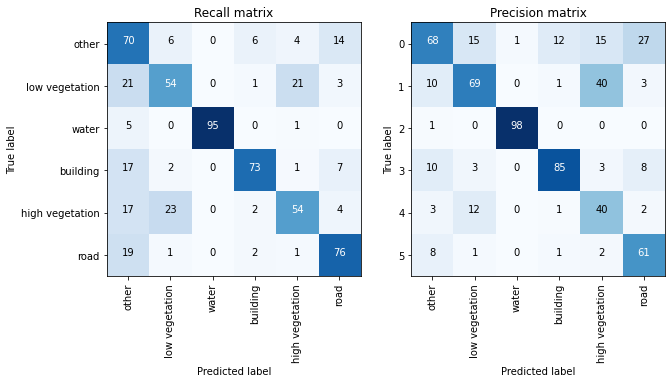

In [7]:
%matplotlib inline

from dl_toolbox.callbacks import plot_confusion_matrix, compute_conf_mat

cm = compute_conf_mat(
    torch.tensor(labels).flatten().cpu(),
    torch.tensor(preds).flatten().cpu(),
    NUM_CLASSES
)

metrics_per_class_df, macro_average_metrics_df, micro_average_metrics_df = dl_inf.cm2metrics(cm.numpy())
metrics_per_class_df.rename(
    index=dict([(i, l) for i, l in enumerate(dataset.labels.keys())]),
    inplace=True
)

print(metrics_per_class_df)
print(macro_average_metrics_df)
print(micro_average_metrics_df)

fig = plot_confusion_matrix(cm.cpu(), class_names=dataset.labels.keys())
fig.show()

#fig = plt.figure(figsize=(20,20))
#subfigs = fig.subfigures(2,1, wspace=0.02)
#subfigs[0] = plot_confusion_matrix(confmat_recall.numpy(), class_names=dataset.labels.keys())
#subfigs[1] = plot_confusion_matrix(confmat_prec.numpy(), class_names=dataset.labels.keys())
#plt.show()

#confmat_recall_fig = plot_confusion_matrix(confmat_recall.numpy(), class_names=dataset.labels.keys())
#plt.title('Recall')
#plt.show()

#confmat_prec_fig = plot_confusion_matrix(confmat_prec.numpy(), class_names=dataset.labels.keys())
#plt.title('Precision')
#plt.show()

#subfigs[1].suptitle('Precision')

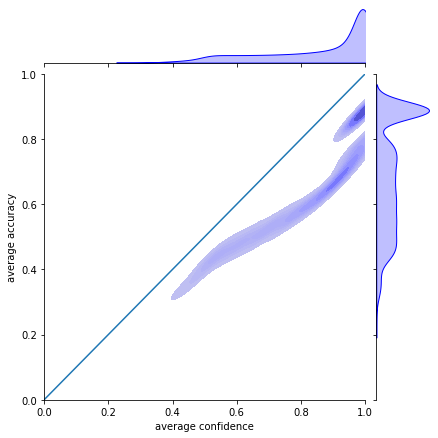

In [12]:
%matplotlib inline

from dl_toolbox.callbacks import plot_calib, compute_calibration_bins

acc_bins, conf_bins, count_bins = compute_calibration_bins(
    torch.linspace(0, 1, 100 + 1),
    torch.tensor(labels).flatten().cpu(),
    confs.flatten().cpu(),
    torch.tensor(preds).flatten().cpu(),
    ignore_idx=None
)

calib_fig = plot_calib(
    count_bins.numpy(),
    acc_bins.numpy(),
    conf_bins.numpy(),
    max_points=10000
)

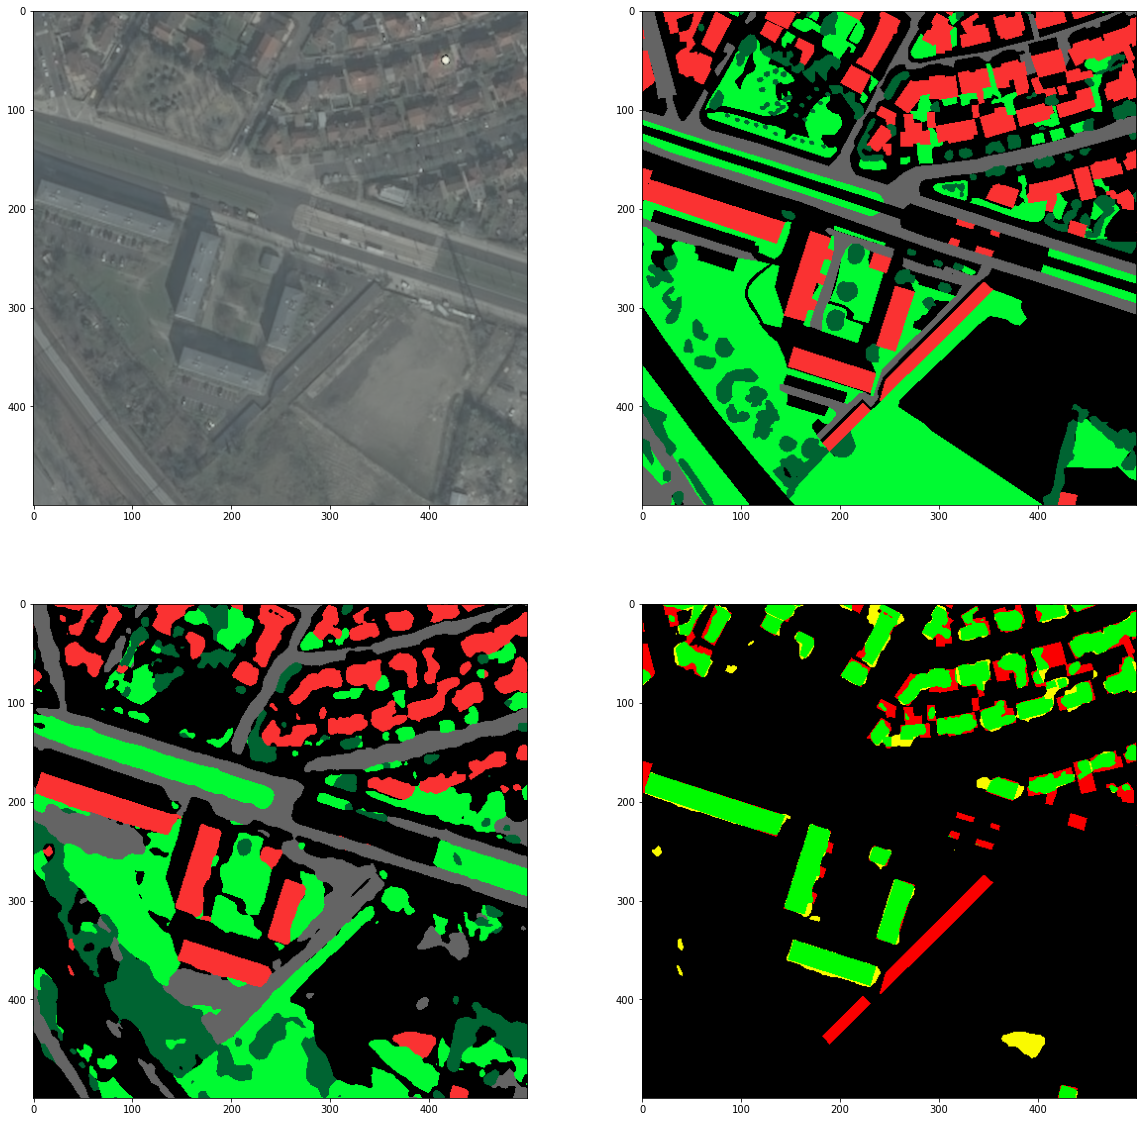

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
from skimage import exposure
from dl_toolbox.utils import LabelsToRGB

zone = np.s_[1000:1500, 1000:1500, ...]

image = dataset.read_image(
    image_path=IMAGE_PATH,
    window=window
)
image = image.transpose(1,2,0)
image = exposure.adjust_gamma(image, 0.3)

overlay = np.zeros(shape=(window.height, window.width, 3), dtype=np.uint8)
label_bool = labels == 3
pred_bool = preds == 3

# Correct predictions (Hits) painted with green
overlay[label_bool & pred_bool] = np.array([0, 250, 0], dtype=overlay.dtype)
# Misses painted with red
overlay[label_bool & ~pred_bool] = np.array([250, 0, 0], dtype=overlay.dtype)
# False alarm painted with yellow
overlay[~label_bool & pred_bool] = np.array([250, 250, 0], dtype=overlay.dtype)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax1.imshow(image[zone])
ax2 = fig.add_subplot(222)
ax2.imshow(LabelsToRGB(dataset.labels)(labels)[zone])
ax3 = fig.add_subplot(223)
ax3.imshow(LabelsToRGB(dataset.labels)(preds)[zone])
ax4 = fig.add_subplot(224)
ax4.imshow(overlay[zone])

In [ ]:
initial_profile = rasterio.open(IMAGE_PATH).profile
OUTPUT = 
#rgb = DigitanieToulouseDs.labels_to_rgb(preds)

dl_inf.write_array(
    inputs=probas,
    tile=TILE,
    output_path=args.output_probas,
    profile=initial_profile
)

In [ ]:
import pydensecrf.densecrf as dcrf

probas_class = probas[1,...]
probas_crf = np.vstack([1-probas_class, probas_class])
unary = -np.log(probas_crf).reshape((2, -1)).astype(np.float32)
d = dcrf.DenseCRF2D(2000, 2000, 2)
d.setUnaryEnergy(unary)
d.addPairwiseGaussian(sxy=3, compat=3)
Q = d.inference(10)
MAP = np.argmax(Q, axis=0)
preds_crf = MAP.reshape((2000,2000))
preds_basic = probas[4,...] > 0.5